Plan is to borrow loaders from some of the other projects:

- ULDA: https://github.com/WonderSeven/ULDA
- https://github.com/AntreasAntoniou/FewShotContinualLearningDataProvider

Or to rewrite the Dataset implementation in UMTRA into torch: https://github.com/siavash-khodadadeh/UMTRA-Release/blob/master/models/umtra/umtra.py

In [ ]:
import learn2learn as l2l
from learn2learn.vision.datasets import MiniImagenet, FullOmniglot

import torchvision
from torchvision import transforms
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
tasksets = l2l.vision.benchmarks.get_tasksets('omniglot',
                                                  train_ways=5,
                                                  train_samples=2*10,
                                                  test_ways=16,
                                                  test_samples=2*16,
                                                  num_tasks=20000,
                                                  root='./data',)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
xs = next(iter(tasksets))

In [ ]:
def c_imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

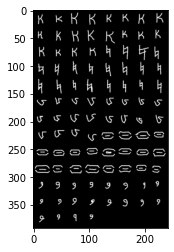

In [ ]:
c_imshow(torchvision.utils.make_grid(xs[0][0]))

In [ ]:
from pathlib import Path

In [ ]:
filename = 'data.hdf5'
data_path = Path('./data/omniglot')
data_file = data_path/filename

In [ ]:
train_labels_file = 'vinyals_train_labels.json'
train_file_path = data_path/train_labels_file

In [ ]:
import h5py
import json
import tensorflow as tf
import torch
import os

In [ ]:
zips_md5 = {
        'images_background': '68d2efa1b9178cc56df9314c21c6e718',
        'images_evaluation': '6b91aef0f799c5bb55b94e3f2daec811'
}

In [ ]:
data = h5py.File(data_file, 'r')

In [ ]:
with open(train_file_path, 'r') as f:
    train_labels = json.load(f)

In [ ]:
data['/'.join(train_labels[10 % len(train_labels)])]

<HDF5 dataset "character11": shape (20, 105, 105), type "|u1">

In [ ]:
image_paths = list(map(lambda x: '/'.join(x), train_labels))

In [ ]:
from sklearn.utils import shuffle

In [ ]:
shuffled_paths = shuffle(image_paths, random_state=42)

In [ ]:
shuffled_paths[0]

'images_background/Japanese_(hiragana)/character26'

In [ ]:
len(shuffled_paths)

1028

In [ ]:
labels_dataset = tf.data.Dataset.range(5)
if False:
    labels_dataset = labels_dataset.map(lambda example: tf.one_hot(example, depth=5))

labels_dataset = labels_dataset.interleave(
    lambda x: tf.data.Dataset.from_tensors(x).repeat(2 * 1),
    cycle_length=5,
    block_length=1
)
labels_dataset = labels_dataset.repeat(32)
labels_dataset = labels_dataset.repeat(150)

In [ ]:
len(list(labels_dataset))

48000

In [ ]:
def gen_labels(n, k, meta_batch_size, steps_per_epoch, one_hot_labels=False):
    labels: torch.tensor = torch.arange(n)
    labels = labels.repeat(2 * k).repeat(meta_batch_size).repeat(steps_per_epoch)
    return labels


In [ ]:
gen_labels(5, 1, 32, 150)

tensor([0, 1, 2,  ..., 2, 3, 4])

In [ ]:
from torch.utils.data import Dataset, ConcatDataset, IterableDataset

In [ ]:
import itertools

In [ ]:
from torchvision.datasets import Omniglot

In [ ]:
xs = Omniglot('./data/', background=True)

In [ ]:
import os
from torch.utils.data import Dataset, ConcatDataset
from torchvision.datasets.omniglot import Omniglot


class FullOmniglot(Dataset):

    def __init__(self, root, transform=None, target_transform=None, download=False):
        self.root = os.path.expanduser(root)
        self.transform = transform
        self.target_transform = target_transform

        # Set up both the background and eval dataset
        omni_background = Omniglot(self.root, background=True, download=download)
        # Eval labels also start from 0.
        # It's important to add 964 to label values in eval so they don't overwrite background dataset.
#         omni_evaluation = Omniglot(self.root,
#                                    background=False,
#                                    download=download,
#                                    target_transform=lambda x: x + len(omni_background._characters))

        self.dataset = omni_background
        self._bookkeeping_path = os.path.join(self.root, 'omniglot-bookkeeping.pkl')

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, item):
        image, character_class = self.dataset[item]
        if self.transform:
            image = self.transform(image)

        if self.target_transform:
            character_class = self.target_transform(character_class)

        return image, character_class


In [ ]:
omniglot = l2l.vision.datasets.FullOmniglot(root='./data', transform=transforms.Compose([transforms.Resize(28, interpolation=Image.LANCZOS), transforms.ToTensor(), lambda x: 1.0 - x,]),
                                                download=True)
omniglot = l2l.data.MetaDataset(omniglot)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
tfms = [
    l2l.data.transforms.NWays(omniglot, n=5),
    l2l.data.transforms.KShots(omniglot, k=1),
    l2l.data.transforms.LoadData(omniglot),
    l2l.data.transforms.RemapLabels(omniglot),
    l2l.data.transforms.ConsecutiveLabels(omniglot),
]

In [ ]:
taskset = l2l.data.TaskDataset(omniglot, tfms, num_tasks=20000)

In [ ]:
from copy import deepcopy

In [ ]:
t2 = deepcopy(taskset)

In [ ]:
tfms2 = [
    l2l.data.transforms.NWays(omniglot, n=5),
    l2l.data.transforms.KShots(omniglot, k=1),
    l2l.data.transforms.LoadData(omniglot),
    l2l.data.transforms.RemapLabels(omniglot),
    l2l.data.transforms.ConsecutiveLabels(omniglot),
    l2l.vision.transforms.RandomClassRotation(dataset, [0.0, 90.0, 180.0, 270.0])
]
t2.task_transforms = tfms2

In [ ]:
X, y = next(iter(taskset))

In [ ]:
import kornia

In [ ]:
affine = kornia.augmentation.RandomAffine(degrees=0, translate=(0.3, 0.3), padding_mode='border')

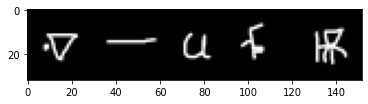

In [ ]:
c_imshow(torchvision.utils.make_grid(X))

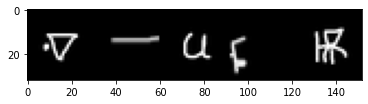

In [ ]:
c_imshow(torchvision.utils.make_grid(affine(X)))

In [ ]:
b = taskset.sample()

In [ ]:
t3 = l2l.vision.benchmarks.get_tasksets('omniglot', root='./data/', train_ways=5, train_samples=1)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
t3.train.sample()

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0.,

In [ ]:
class CTaskset(l2l.data.TaskDataset):
    def __init__(self, dataset, task_transforms=None, num_tasks=-1, task_collate=None):
        super().__init__(dataset, task_transforms=task_transforms, num_tasks=num_tasks, task_collate=task_collate)
    
    def get_task(self, task_description):
        all_data = []
        for data_description in task_description:
            data = data_description.index
            for transform in data_description.transforms:
                data = transform(data)
            all_data.append(data)
        return self.task_collate(all_data)
    
    def __getitem__(self, i):
        if self.num_tasks == -1:
            return self.get_task(self.sample_task_description())
        

In [ ]:
class Omniglot(Dataset):
    def __init__(self, root, transform=None, mode='train'):
        self.root = Path(root)
        filename = 'data.hdf5'
        train_labels_file = 'vinyals_train_labels.json'
        self.data_file = self.root/filename
        self.train_file_path = self.root/train_labels_file
        self.zips_md5 = {
            'images_background': '68d2efa1b9178cc56df9314c21c6e718',
            'images_evaluation': '6b91aef0f799c5bb55b94e3f2daec811'
            }
        self._data = None
        self._labels = None
    
    @property
    def data(self):
        if self._data is None:
            self._data = h5py.File(self.data_file)
        return self._data

    def get_img_paths(self):
        with open(self.train_file_path, 'r') as f:
            train_paths = json.load(f)
        image_paths = list(map(lambda x: '/'.join(x), train_paths))
        instance_groups = []
        for class_name in image_paths:
            instance_groups.extend(data[class_name])

    def make_labels(self, idx):
        labels = torch.arange(n)
        self._labels = labels
        gen = itertools.cycle(labels)
        lb = next(itertools.islice(itertools.cycle(labels), idx))
        return lb
    
    def __getitem__(self, idx):
